# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.


---------------------------
Running OCR on file: a-0.png
Searching for Christopher in a-0.png, size = (3600, 6300) ...
found string Christopher
Getting faces from  a-0.png
Found 6 faces in a-0.png
Finished.
a-0.png has 6 faces
cellDims = (191, 191)
totalFaces = 6
sheetDims = (955, 382)


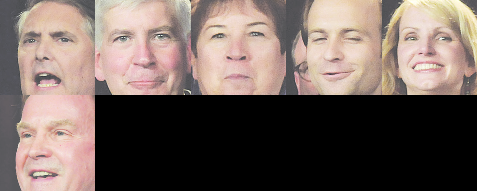

In [53]:
import zipfile
import pytesseract
import PIL
from PIL import Image
from PIL import ImageFile
import pytesseract
import cv2 as cv
import numpy as np
import math

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

#
# Global data structure for results.
# globalData = [{'filename': string, pilImage': object, 'text' : string, 'faces': [] }]
#
globalData = []

def getSmallestFace(imageDict):
    """ Return the dimensions of the face (a tuple) with the smallest width"""
    sortedList = sorted(imageDict['faces'], key = lambda x: x[2])
    smallestDim = (sortedList[0][2], sortedList[0][3])
    return (sortedList[0][2], sortedList[0][3])
            
def getFacesFromImage(pil_image):
    open_cv_image = np.array(pil_image) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    gray = cv.cvtColor(open_cv_image, cv.COLOR_BGR2GRAY)
    # This function returns a list of objects as rectangles. 
    faces = face_cascade.detectMultiScale(gray, 1.35)
    #faces = face_cascade.detectMultiScale(gray)
    return faces

def getImageFromZip(zfile, filename):
        """ 
        Extract a PIL compatible image from a zip archive.
        
        :param zfile: The path to a zip archive (string).
        :param filename: Image filename within the zip archive (string).
        :returns: A `~PIL.Image.Image` object.
        """
        myzip = zipfile.ZipFile(zfile, 'r')
        fp = myzip.read(filename)
        p = ImageFile.Parser()
        p.feed(fp)
        img = p.close()
        return img

# def getFaces(image):
# """Return a list of face rectangles"""

def getTextFromImage(image):
    """
    Return a string of text from an image.
    
    :param image: PIL compatible image
    :return text(string)
    """
    
    # The following did not improve OCR:
    image = image.convert('L')
    image = image.convert('1')
    #process_image(image)
    text = pytesseract.image_to_string(image)
    return text

def displayFaces(i):
        cellDims = getSmallestFace(i)
        print('cellDims =', cellDims)
        totalCells = len(i['faces']) 
        print('totalFaces =', totalCells)
        cellsPerRow = 5
        sheetDims = (0, 0)
        sheetDims = (cellsPerRow * cellDims[0], math.ceil(totalCells / cellsPerRow) * cellDims[1])
        print('sheetDims =', sheetDims)
        # create a contact sheet
        img = globalData[0]['pilImage']
        rec = globalData[0]['faces'][0]
        c = (rec[0], rec[1], rec[0] + rec[2], rec[1] + rec[3])
        first_image = img.crop(c)
        # print('first_image =', first_image)
        #cellDims = (191, 191) # Set to the smallest face?
    
        contact_sheet=PIL.Image.new(first_image.mode, sheetDims)

        x = 0
        y = 0
        
        for rec in i['faces']:
            # Paste the current image into the contact sheet
            (left, upper, right, lower) = rec
            w = left + right
            h = upper + lower
            c = (left, upper, w, h)
            #print('rec = {}, crop = {}'.format(rec, c))
            #i['pilImage'].crop(c)
            #contact_sheet.paste(i['pilImage'].crop(c), (x, y) )
            faceImage = i['pilImage'].crop(c)
            #print('\nface img =', faceImage)
            faceImage.thumbnail(cellDims)
            #print('thumbnail image = \n', faceImage)
            #contact_sheet.paste(i['pilImage'].crop(c), (x, y) )
            contact_sheet.paste(faceImage, (x, y) )
            # Now we update our X position. If it is going to be the width of the image, then we set it to 0
            # and update Y as well to point to the next "line" of the contact sheet.
            if x + cellDims[0] == contact_sheet.width:
                x = 0
                y = y + cellDims[1]
            else:
                x = x + cellDims[0]

        # resize and display the contact sheet
        #print('Display contact_sheet')
        contact_sheet = contact_sheet.resize((int(contact_sheet.width/2),int(contact_sheet.height/2) ))
        display(contact_sheet)

#
# Begin main 
#
# This should be a function: processImageSet(zipArchive, globalDataStructure)
#
zipArchive = 'readonly/small_img.zip'
#zipArchive = 'readonly/images.zip'

# Move the text search from this loop to the final loop.  
searchTerms = ['Mark', 'Christopher', 'pizza']
searchTerms = ['Christopher']

#
# The main processing loop. It searches each image in the zipfile
# for text and faces. The results are stored as dictionaries in the 
# globalData list defined above.
#

for file in ['a-0.png']:
#for file in zipfile.ZipFile(zipArchive, 'r').namelist():
    d = {}
    d['filename'] = file
    d['pilImage'] = getImageFromZip(zipArchive, file)
    print('\n---------------------------')
    print('Running OCR on file:', file)
    d['text'] = getTextFromImage(d['pilImage'])
    for search in searchTerms:
        print('Searching for {} in {}, size = {} ...'.format(search, file, d['pilImage'].size))
        if search in d['text']:
            print('found string {}'.format(search))

    print('Getting faces from ', file)
    d['faces'] = getFacesFromImage(d['pilImage'])
    print('Found {} faces in {}'.format(len(d['faces']), file))
        
    globalData.append(d)

    print('Finished.') 

#
# This should be a function: searchAndDisplay(globalDataStructure, searchTerms)
#
# Search the globalData structure for text and face rectangles.
#
for i in globalData:
    if len(i['faces']) > 0:
        print('{} has {} faces'.format(i['filename'], len(i['faces'])))
        displayFaces(i)
    else:
        print('Results found in file {}'.format(i['filename']))
        print('But sorry, there were no faces in that file!')
    
    